**IFSP - Campus Campinas** <br>
**Pós-graduação em Ciência de Dados** <br>
**Disciplina D3TOP/2023 – Tópicos em Ciência de Dados** <br>

**Projeto em Grupo - Parte 2**

#### Sprint 3 - v 2.3 
- limpeza inicial de linhas com NaN no campo 'Texto'
- pre-processamento com Spacy seguido de Neattext
- feature extraction com TfidfVectorizer na coluna 'Texto' da PLO
- treinamento com LogisticRegression
- rodado em PC local (não AWS)


Professor: Samuel Martins (samuel.martins@ifsp.edu.br)<br>
Aluno: Swift Motoo Yaguchi - CP301665X

------

### 1. Etapa de limpeza e pré-processamento

##### Instalando bibliotecas

In [1]:
#Upgrade dependencies
#!pip install --upgrade pip
#!pip install --upgrade scikit-learn
#!pip install --upgrade wordcloud
#!pip install --upgrade sagemaker

In [2]:
import pandas as pd
import numpy as np

##### Leitura da base de dados

In [3]:
df = pd.read_csv('PLO 2019 v3a.csv', sep=';')
df.head()

,Texto,Ementa,Vereador,Data,Nota,isUtil
0,Art. I Fica denominado Praça Sandra Hitomi Ta...,DENOMINA PRAÇA SANDRA HITOMI TAKAHASHI UM SIST...,Carmo Luiz,2019,9,não
1,Art. lº Ficam proibidos a comercialização e o...,PROÍBE O COMÉRCIO E O USO DOS PRODUTOS QUE ESP...,Luiz Rossini,2019,13,não
2,Art. 1 0 Poder Executivo municipal deverá disp...,DISPÕE SOBRE O ACESSO ÀS INFORMAÇÕES A RESPEIT...,Luiz Cirilo,2019,1,sim
3,Art. 1 Fica denominada Praça Iracema Costa a P...,DENOMINA PRAÇA IRACEMA COSTA UMA PRAÇA PÚBLICA...,Carlão do PT,2019,9,não
4,Art. 1 Ficam alterados os SS I P e 3 2 do art....,ALTERA A REDAÇÃO DOS §§ 1º E 3º DO ART. 2º DA ...,Paulo Galterio,2019,7,não


In [4]:
# Verificando se base de dados tem valores ausentes
df.isna().sum()

Texto       235
Ementa        0
Vereador    235
Data          0
Nota          0
isUtil        0
dtype: int64

Vamos remover as lihas com campos da coluna 'Texto' e 'Vereador' da PLO sem dados

In [5]:
# Removendo as linhas em branco
df = df.dropna()

In [6]:
df.isna().sum()

Texto       0
Ementa      0
Vereador    0
Data        0
Nota        0
isUtil      0
dtype: int64

In [7]:
print('O tamanho do dataset é:', df.shape)

O tamanho do dataset é: (99, 6)


In [8]:
df['isUtil'].value_counts()

isUtil
não    82
sim    17
Name: count, dtype: int64

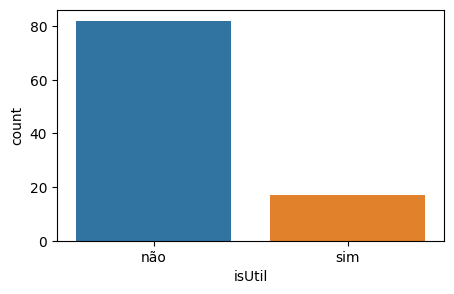

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='isUtil')
plt.show()

Nota-se que o resultado é desbalanceado

In [10]:
df['Nota'].value_counts()

Nota
9     24
7     17
6     17
14     8
5      5
11     5
2      5
1      4
12     4
10     4
13     3
3      2
4      1
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Nota'>

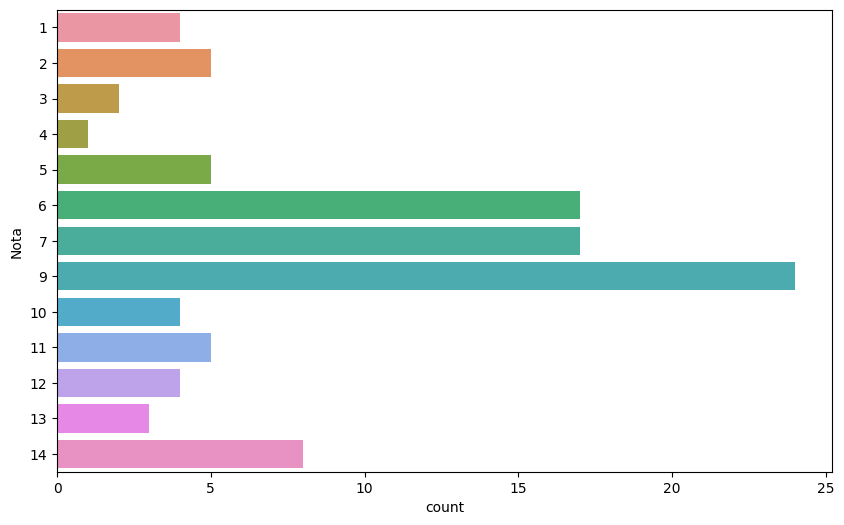

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, y='Nota')

Curioso observar que sumiram as linhas com Nota 8

<Axes: xlabel='count', ylabel='Nota'>

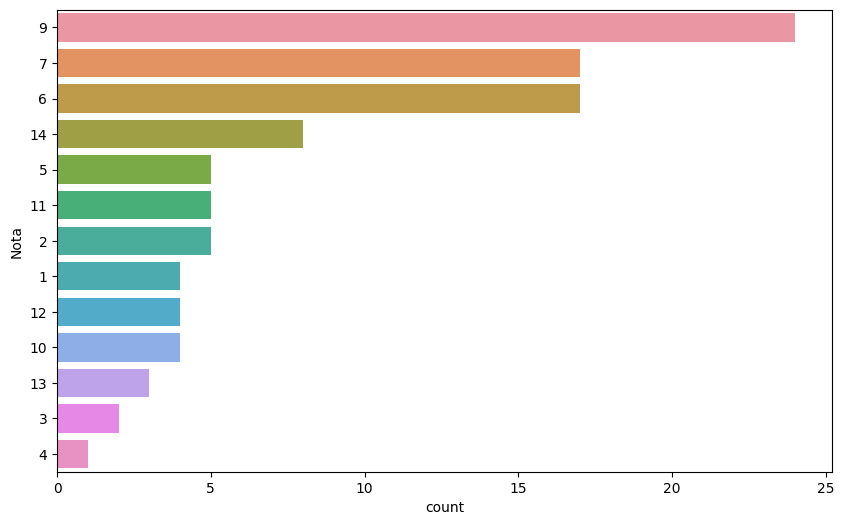

In [13]:
order = df['Nota'].value_counts().index

plt.figure(figsize=(10,6))
sns.countplot(data=df, y='Nota', order=order)

Observa-se que o desbalanceamento dos dados é causado por PLOs com 'Nota' de valores maiores

##### Label Classes

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['isUtil'])

LabelEncoder()

In [15]:
print(f'Class labels')

for label, class_ in enumerate(label_encoder.classes_):
    print(f'{class_} ==> {label}')

Class labels
não ==> 0
sim ==> 1


In [16]:
df['Label'] = label_encoder.transform(df['isUtil'])

In [17]:
df.head()

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label
0,Art. I Fica denominado Praça Sandra Hitomi Ta...,DENOMINA PRAÇA SANDRA HITOMI TAKAHASHI UM SIST...,Carmo Luiz,2019,9,não,0
1,Art. lº Ficam proibidos a comercialização e o...,PROÍBE O COMÉRCIO E O USO DOS PRODUTOS QUE ESP...,Luiz Rossini,2019,13,não,0
2,Art. 1 0 Poder Executivo municipal deverá disp...,DISPÕE SOBRE O ACESSO ÀS INFORMAÇÕES A RESPEIT...,Luiz Cirilo,2019,1,sim,1
3,Art. 1 Fica denominada Praça Iracema Costa a P...,DENOMINA PRAÇA IRACEMA COSTA UMA PRAÇA PÚBLICA...,Carlão do PT,2019,9,não,0
4,Art. 1 Ficam alterados os SS I P e 3 2 do art....,ALTERA A REDAÇÃO DOS §§ 1º E 3º DO ART. 2º DA ...,Paulo Galterio,2019,7,não,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 98
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Texto     99 non-null     object
 1   Ementa    99 non-null     object
 2   Vereador  99 non-null     object
 3   Data      99 non-null     int64 
 4   Nota      99 non-null     int64 
 5   isUtil    99 non-null     object
 6   Label     99 non-null     int32 
dtypes: int32(1), int64(2), object(4)
memory usage: 5.8+ KB


### 2. Pré-Processamento de texto: 

##### Remoção inicial de algumas das palavras irrelevantes, lemmatizaton, nos dados de texto, utilizando a bilioteca SpaCy

In [19]:
#!pip install spacy
# PLOs são em português 
#!python -m spacy download pt  # Portuguese

In [20]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt import Portuguese
nlp = Portuguese()

In [21]:
nlp_spacy = spacy.load("pt_core_news_sm")   # Portuguese small vocabulary

In [22]:
def remove_stopwords(doc: spacy.tokens.doc.Doc) -> list:
    tokens_without_stopwords = [token.text for token in doc if not token.is_stop]
    text_without_stopwords = ' '.join(tokens_without_stopwords)
    return text_without_stopwords

In [23]:
import re
def process_text(texts):
    final_text_list=[]
    for sent in texts:
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.sub('[^\w\s]', '', sent)  # Remove punctuations
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        filtered_sentence=[]
        sent1 = nlp(sent)
        sent2 = remove_stopwords(sent1)
        filtered_sentence.append(sent2)
        final_string = " ".join(filtered_sentence) # Final string of cleaned words
        final_text_list.append(final_string)
    return final_text_list

In [24]:
df

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label
0,Art. I Fica denominado Praça Sandra Hitomi Ta...,DENOMINA PRAÇA SANDRA HITOMI TAKAHASHI UM SIST...,Carmo Luiz,2019,9,não,0
1,Art. lº Ficam proibidos a comercialização e o...,PROÍBE O COMÉRCIO E O USO DOS PRODUTOS QUE ESP...,Luiz Rossini,2019,13,não,0
2,Art. 1 0 Poder Executivo municipal deverá disp...,DISPÕE SOBRE O ACESSO ÀS INFORMAÇÕES A RESPEIT...,Luiz Cirilo,2019,1,sim,1
3,Art. 1 Fica denominada Praça Iracema Costa a P...,DENOMINA PRAÇA IRACEMA COSTA UMA PRAÇA PÚBLICA...,Carlão do PT,2019,9,não,0
4,Art. 1 Ficam alterados os SS I P e 3 2 do art....,ALTERA A REDAÇÃO DOS §§ 1º E 3º DO ART. 2º DA ...,Paulo Galterio,2019,7,não,0
...,...,...,...,...,...,...,...
94,"Art. 1º Revoga-se a Lei nº 12.551, de 10 de ma...","REVOGA A LEI Nº 12.551, DE 10 DE MAIO DE 2006,...",Permínio Monteiro,2019,9,não,0
95,A PARTIR DESTA DATA E CONFORME MANIFESTAÇÃO DA...,ESTABELECE A POSSIBILIDADE DE CORTE E/OU PODA ...,Nelson Hossri,2019,3,sim,1
96,Art. 1º Fica vedada a aquisição de copos e rec...,DISPÕE SOBRE A VEDAÇÃO DA AQUISIÇÃO DE COPOS E...,Paulo Haddad,2019,14,não,0
97,Art. 1º Fica denominado Praça Cyro Baldin o Si...,DENOMINA PRAÇA CYRO BALDIN UM SISTEMA DE RECRE...,Carmo Luiz,2019,9,não,0


In [25]:
print('Processand a coluna Texto')
df['Texto'] = process_text(df['Texto'].tolist())

Processand a coluna Texto


In [26]:
print('Processando a coluna Ementa')
df['Ementa'] = process_text(df['Ementa'].tolist())

Processando a coluna Ementa


In [27]:
df

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label
0,art i fica denominado praça sandra hitomi taka...,denomina praça sandra hitomi takahashi recreio...,Carmo Luiz,2019,9,não,0
1,art lº ficam proibidos comercialização uso esp...,proíbe comércio uso produtos especifica acondi...,Luiz Rossini,2019,13,não,0
2,art 1 0 executivo municipal disponibilizar sit...,dispõe acesso informações respeito obras públi...,Luiz Cirilo,2019,1,sim,1
3,art 1 fica denominada praça iracema costa praç...,denomina praça iracema costa praça pública mun...,Carlão do PT,2019,9,não,0
4,art 1 ficam alterados ss i p 3 2 art 2 2 lei n...,altera redação 1º 3º art 2º lei nº 14789 4 a...,Paulo Galterio,2019,7,não,0
...,...,...,...,...,...,...,...
94,art 1º revogase lei nº 12551 10 maio 2006 deno...,revoga lei nº 12551 10 maio 2006 denomina praç...,Permínio Monteiro,2019,9,não,0
95,data conforme manifestação procuradoria legisl...,estabelece possibilidade corte eou poda árvore...,Nelson Hossri,2019,3,sim,1
96,art 1º fica vedada aquisição copos recipientes...,dispõe vedação aquisição copos recipientes des...,Paulo Haddad,2019,14,não,0
97,art 1º fica denominado praça cyro baldin recre...,denomina praça cyro baldin recreio município c...,Carmo Luiz,2019,9,não,0


##### Divisão dos dados para treinamento e teste

In [28]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

In [29]:
print(f"===> TRAIN\n{df_train['Label'].value_counts() / df_train.shape[0]}\n")
print(f"===> TEST\n{df_test['Label'].value_counts() / df_test.shape[0]}")

===> TRAIN
Label
0    0.822785
1    0.177215
Name: count, dtype: float64

===> TEST
Label
0    0.85
1    0.15
Name: count, dtype: float64


In [30]:
# save the datasets
df_train.to_csv('test_dataset_train_3.csv', sep=';', index = False)
df_test.to_csv('test_dataset_test_3.csv', sep=';', index = False)

In [31]:
df_train

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label
59,art 10 fica proibido venda comercialização b...,proíbe venda brinquedos constituem réplicas si...,Carmo Luiz,2019,13,não,0
30,art i fica assegurada criança adolescente pai ...,assegura criança adolescente pai mãe responsáv...,Carmo Luiz,2019,7,não,0
62,art 1º fica ins tuído programa municipal popul...,institui programa municipal população imigrant...,Carlão do PT,2019,12,não,0
67,art 10 ficam obrigadas escolas rede privada mu...,dispõe obrigatoriedade escolas rede privada mu...,Gustao Petta,2019,12,não,0
97,art 1º fica denominado praça cyro baldin recre...,denomina praça cyro baldin recreio município c...,Carmo Luiz,2019,9,não,0
...,...,...,...,...,...,...,...
14,projeto lei ordinária passou tramitar projeto ...,institui programa árvores qualidade vida munic...,Luiz Rossini,2019,12,não,0
69,data conforme manifestação procuradoria legisl...,acrescenta art 20a lei nº 9953 18 dezembro 199...,Marcelo Silva,2019,11,não,0
72,art 1º fica denominada praça etelvina ramos pr...,denomina praça etelvina ramos praça pública mu...,Luiz Rossini,2019,9,não,0
23,art 1 lei objetivo implantar postos coletas to...,dispõe obrigatoriedade implantação postos cole...,Cidão Santos,2019,6,não,0


In [32]:
df_test

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label
25,art 1 fica declarada órgão utilidade pública m...,declara órgão utilidade pública municipal asso...,Mariana Conti,2019,7,não,0
19,art 1 fica denominada praça jacira guedes pint...,denomina praça jacira guedes pinto alberto pra...,Marcos Bernardelli,2019,9,não,0
92,art 1º fica alterado art 1º lei nº 14045 7 abr...,altera art 1º lei nº 14045 07 abril 2011 inclu...,Professor Alberto,2019,10,não,0
95,data conforme manifestação procuradoria legisl...,estabelece possibilidade corte eou poda árvore...,Nelson Hossri,2019,3,sim,1
1,art lº ficam proibidos comercialização uso esp...,proíbe comércio uso produtos especifica acondi...,Luiz Rossini,2019,13,não,0
26,art i encaminharem nome consumidor inadimplent...,dispõe obrigatoriedade empresas credoras notif...,Cidão Santos,2019,6,não,0
37,art 10 fica declarada órgão utilidade pública ...,declara órgão utilidade pública municipal asso...,Vinicius Gratti,2019,7,não,0
40,art 1 2 fica acrescido s 5 2 art 3 2 lei n 635...,acrescenta 5º art 3º suprime inciso iii art 5º...,Tenente Santini,2019,5,sim,1
86,art 1º estabelecimentos situados âmbito municí...,dispõe disponibilização espaços destinados col...,Permínio Monteiro,2019,14,não,0
79,art 1º fica denominada praça maria souza ruiz ...,denomina praça maria souza ruiz praça pública ...,Carlão do PT,2019,9,não,0


##### Nova remoção na coluna 'Texto' usando biblioteca neattext
- lowering, expand contractions
- remove:
  + punctuations, stop words, urls, emails, numbers, emojis, phone numbers, multiple whitespaces, currency symbols, special characters

In [33]:
import neattext.functions as ntx

def text_preprocessing(text_in: str) -> str:
    text = text_in.lower()
    text = ntx.fix_contractions(text)
    text = ntx.remove_punctuations(text)
    text = ntx.remove_stopwords(text)
    text = ntx.remove_urls(text)
    text = ntx.remove_emails(text)
    text = ntx.remove_numbers(text)
    text = ntx.remove_emojis(text)
    text = ntx.remove_phone_numbers(text)
    text = ntx.remove_multiple_spaces(text)
    text = ntx.remove_currency_symbols(text)
    text = ntx.remove_special_characters(text)
    return text

In [34]:
# progress bar in pandas
#!pip install tqdm

In [35]:
from tqdm import tqdm
tqdm.pandas()  # it enables some new progress bar functions/methods for pandas

In [36]:
# pre-process the training set
df_train['Texto-pre'] = df_train['Texto'].progress_apply(lambda text: text_preprocessing(text))

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 346.70it/s]


In [37]:
df_train.head()

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label,Texto-pre
59,art 10 fica proibido venda comercialização b...,proíbe venda brinquedos constituem réplicas si...,Carmo Luiz,2019,13,não,0,art fica proibido venda comercializao brinqued...
30,art i fica assegurada criança adolescente pai ...,assegura criança adolescente pai mãe responsáv...,Carmo Luiz,2019,7,não,0,art fica assegurada criana adolescente pai me ...
62,art 1º fica ins tuído programa municipal popul...,institui programa municipal população imigrant...,Carlão do PT,2019,12,não,0,art fica ins tudo programa municipal populao ...
67,art 10 ficam obrigadas escolas rede privada mu...,dispõe obrigatoriedade escolas rede privada mu...,Gustao Petta,2019,12,não,0,art ficam obrigadas escolas rede privada munic...
97,art 1º fica denominado praça cyro baldin recre...,denomina praça cyro baldin recreio município c...,Carmo Luiz,2019,9,não,0,art fica denominado praa cyro baldin recreio ...


In [38]:
# pre-process the training set
df_test['Texto-pre'] = df_test['Texto'].progress_apply(lambda text: text_preprocessing(text))

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 465.41it/s]


In [39]:
df_test.head()

,Texto,Ementa,Vereador,Data,Nota,isUtil,Label,Texto-pre
25,art 1 fica declarada órgão utilidade pública m...,declara órgão utilidade pública municipal asso...,Mariana Conti,2019,7,não,0,art fica declarada rgo utilidade pblica munici...
19,art 1 fica denominada praça jacira guedes pint...,denomina praça jacira guedes pinto alberto pra...,Marcos Bernardelli,2019,9,não,0,art fica denominada praa jacira guedes pinto a...
92,art 1º fica alterado art 1º lei nº 14045 7 abr...,altera art 1º lei nº 14045 07 abril 2011 inclu...,Professor Alberto,2019,10,não,0,art fica alterado art lei n abril passa vigo...
95,data conforme manifestação procuradoria legisl...,estabelece possibilidade corte eou poda árvore...,Nelson Hossri,2019,3,sim,1,data conforme manifestao procuradoria legislat...
1,art lº ficam proibidos comercialização uso esp...,proíbe comércio uso produtos especifica acondi...,Luiz Rossini,2019,13,não,0,art l ficam proibidos comercializao uso espuma...


In [40]:
# save the preprocessed datasets
df_train.to_csv('test_dataset_train_preprocessed.csv', sep=';', index=False)
df_test.to_csv('test_dataset_test_preprocessed.csv', sep=';', index=False)

### 3. Feature Extraction

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(df_train['Texto-pre'])
y_train = df_train['Label']

X_test = tfidf.transform(df_test['Texto-pre'])
y_test = df_test['Label']

In [48]:
X_train.shape, X_test.shape

((79, 2124), (20, 2124))

In [49]:
print(f'Vocabulary size: {len(tfidf.vocabulary_)}')

Vocabulary size: 2124


### 4. Treinamento de modelos

In [50]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', n_jobs=-1)

logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [51]:
# prediction on training set
y_train_pred = logreg.predict(X_train)

In [52]:
from sklearn.metrics import classification_report

#print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.82      1.00      0.90        14

    accuracy                           0.96        79
   macro avg       0.91      0.98      0.94        79
weighted avg       0.97      0.96      0.96        79



In [53]:
from sklearn.metrics import f1_score

f1_train = f1_score(y_train, y_train_pred, average='macro')

print(f'F1 Train: {f1_train}')

F1 Train: 0.9398018796037592


In [54]:
from sklearn.metrics import balanced_accuracy_score

balacc_train = balanced_accuracy_score(y_train, y_train_pred)

print(f'Balanced Acc Train: {balacc_train}')

Balanced Acc Train: 0.976923076923077


#### Evaluate the model on the Test Set

In [55]:
# prediction on testing set
y_test_pred = logreg.predict(X_test)

In [56]:
#from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.67      0.67      0.67         3

    accuracy                           0.90        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.90      0.90      0.90        20



In [57]:
from sklearn.metrics import f1_score
f1_test = f1_score(y_test, y_test_pred, average='macro')
print(f'F1 Test: {f1_test}')

F1 Test: 0.803921568627451


O resultado **F1 score** melhorou bastante com a remoção de linhas com 'Texto' e 'Vereador' nulos